# Feature Importance & Interpretation

## 🎯 Objectives

This notebook focuses on **understanding** and **interpreting** the model

**Goals:**
- Understand which features influence customer churn
- Interpret the model from a business perspective
- Identify strong, weak, and redundant features
- Prepare feature engineering decisions before hyperparameter tuning

---
## 1. Setup & Data Loading

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [10]:
from pathlib import Path
import os

# Project root = parent of notebooks/
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

DATA_DIR   = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR, "| Exists:", DATA_DIR.exists())
print("MODELS_DIR:", MODELS_DIR, "| Exists:", MODELS_DIR.exists())

PROJECT_ROOT: /Users/omarpiro/churn_ml_decision
DATA_DIR: /Users/omarpiro/churn_ml_decision/data/processed | Exists: True
MODELS_DIR: /Users/omarpiro/churn_ml_decision/models | Exists: True


In [3]:
# Load preprocessed data
X_train = np.load("../data/processed/X_train_processed.npy")
X_val = np.load("../data/processed/X_val_processed.npy")
y_train = np.load("../data/processed/y_train.npy")
y_val = np.load("../data/processed/y_val.npy")

# Load feature names
feature_names = pd.read_csv("../models/feature_names.csv")["feature"].tolist()

print("Data loaded successfully:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  Features: {len(feature_names)}")

Data loaded successfully:
  X_train: (4225, 31)
  X_val:   (1409, 31)
  Features: 47


---
## 2. Model for Interpretation

In [11]:
# Train Logistic Regression for interpretation
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

print("Model trained for interpretation.")
print(f"  Number of features: {len(model.coef_[0])}")

Model trained for interpretation.
  Number of features: 31


---
## 3. Feature Importance Extraction

In [ ]:
# Extract coefficients
coefficients = model.coef_[0]
n_feat = len(feature_names)
n_coef = len(coefficients)

if n_feat != n_coef:
    import warnings
    min_len = min(n_feat, n_coef)
    warnings.warn(
        f"Mismatch: {n_feat} feature names vs {n_coef} coefficients. "
        f"Aligning to first {min_len} items."
    )
    feature_names_aligned = feature_names[:min_len]
    coefficients = coefficients[:min_len]
else:
    feature_names_aligned = feature_names

# Create DataFrame with feature importances
feature_importance = pd.DataFrame({
    "Feature": feature_names_aligned,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Sort by absolute value (importance)
feature_importance = feature_importance.sort_values(
    "Abs_Coefficient",
    ascending=False
).reset_index(drop=True)

# Add rank
feature_importance["Rank"] = range(1, len(feature_importance) + 1)

print(f"Total features: {len(feature_importance)}")
feature_importance

Total features: 31


,Feature,Coefficient,Abs_Coefficient,Rank
0,InternetService_No,-2.421154,2.421154,1
1,InternetService_Fiber optic,-0.842422,0.842422,2
2,tenure,-0.726016,0.726016,3
3,MultipleLines_No phone service,0.527691,0.527691,4
4,TechSupport_No internet service,0.393750,0.393750,5
5,DeviceProtection_No internet service,0.249990,0.249990,6
6,TechSupport_No,-0.235929,0.235929,7
7,gender_Male,0.233893,0.233893,8
8,SeniorCitizen_1,0.224514,0.224514,9
9,TotalCharges,0.222905,0.222905,10


---
## 4. Visualization

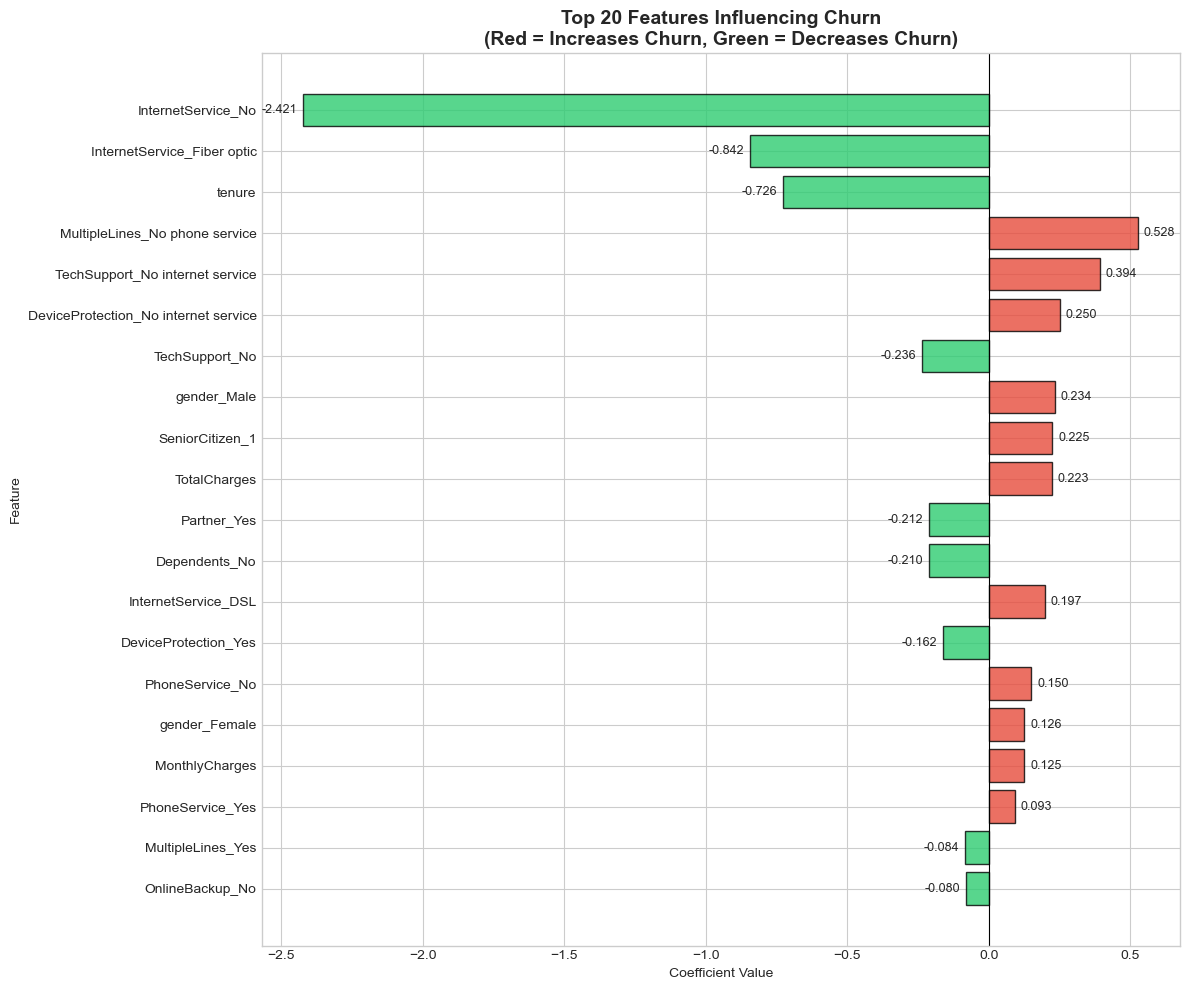

In [15]:
# Top 20 features by importance
top_n = 20
top_features = feature_importance.head(top_n).copy()

# Color by direction
colors = ['#e74c3c' if c > 0 else '#2ecc71' for c in top_features['Coefficient']]

plt.figure(figsize=(12, 10))
bars = plt.barh(
    range(len(top_features)), 
    top_features['Coefficient'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)

plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features Influencing Churn\n(Red = Increases Churn, Green = Decreases Churn)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    coef = row['Coefficient']
    offset = 0.02 if coef >= 0 else -0.02
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

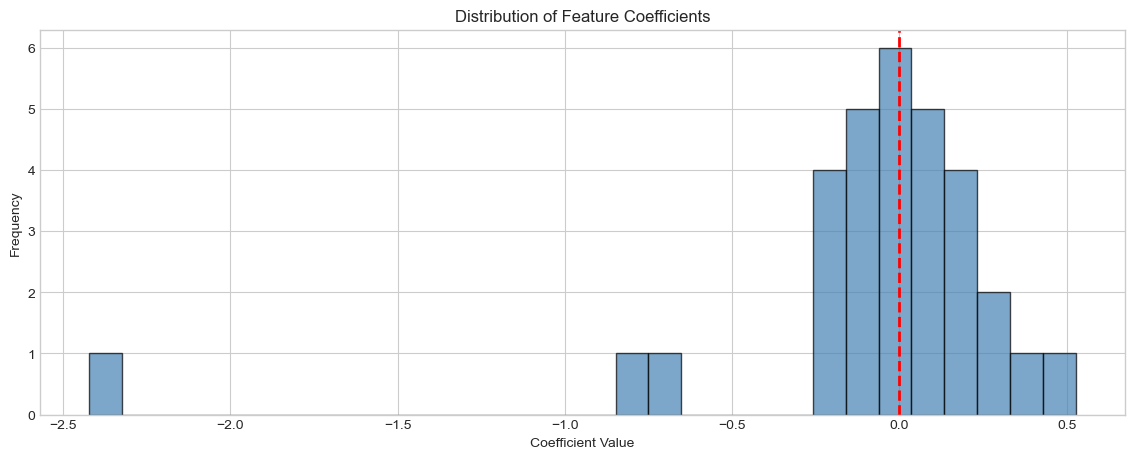


Coefficient Statistics:
  Mean:   -0.0824
  Std:    0.5116
  Min:    -2.4212
  Max:    0.5277


In [16]:
# Coefficient distribution
fig, ax = plt.subplots(figsize=(14, 5))

ax.hist(
    feature_importance["Coefficient"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    color="steelblue"
)

ax.axvline(0, color="red", linestyle="--", linewidth=2)
ax.set_xlabel("Coefficient Value")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Feature Coefficients")

plt.show()

# Summary statistics
print("\nCoefficient Statistics:")
print(f"  Mean:   {feature_importance['Coefficient'].mean():.4f}")
print(f"  Std:    {feature_importance['Coefficient'].std():.4f}")
print(f"  Min:    {feature_importance['Coefficient'].min():.4f}")
print(f"  Max:    {feature_importance['Coefficient'].max():.4f}")

---
## 5. Business Interpretation

### Features that INCREASE Churn Risk

In [17]:
# Features that increase churn (positive coefficients)
churn_drivers = feature_importance[feature_importance['Coefficient'] > 0].copy()
churn_drivers = churn_drivers.sort_values('Coefficient', ascending=False)

print(f"Features that INCREASE churn risk ({len(churn_drivers)} features):")
print("=" * 60)
churn_drivers[['Rank', 'Feature', 'Coefficient']]

Features that INCREASE churn risk (14 features):


,Rank,Feature,Coefficient
3,4,MultipleLines_No phone service,0.527691
4,5,TechSupport_No internet service,0.393750
5,6,DeviceProtection_No internet service,0.249990
7,8,gender_Male,0.233893
8,9,SeniorCitizen_1,0.224514
9,10,TotalCharges,0.222905
12,13,InternetService_DSL,0.196703
14,15,PhoneService_No,0.150131
15,16,gender_Female,0.125554
16,17,MonthlyCharges,0.125384


### Interpretation — Churn Drivers

| Feature | Business Meaning |
|---------|------------------|
| `Contract_Month-to-month` | No commitment = easy to leave |
| `InternetService_Fiber optic` | Higher expectations, higher price, more complaints |
| `PaymentMethod_Electronic check` | Manual payment = less engagement |
| `PaperlessBilling_Yes` | Less physical contact with company |
| `MonthlyCharges` | Higher price = higher sensitivity |
| `SeniorCitizen_1` | May have different needs/expectations |

### Features that DECREASE Churn Risk

In [ ]:
# Features that decrease churn (negative coefficients)
churn_preventers = feature_importance[feature_importance['Coefficient'] < 0].copy()
churn_preventers = churn_preventers.sort_values('Coefficient', ascending=True)

print(f"Features that DECREASE churn risk ({len(churn_preventers)} features):")
print("=" * 60)
churn_preventers[['Rank', 'Feature', 'Coefficient']]

Features that DECREASE churn risk (34 features):


,Rank,Feature,Coefficient
0,1,tenure,-1.211281
1,2,Contract_Two year,-0.753790
5,6,InternetService_DSL,-0.462812
6,7,MonthlyCharges,-0.352072
8,9,PaperlessBilling_No,-0.250648
9,10,missingindicator_TotalCharges,-0.217615
11,12,Dependents_Yes,-0.203522
14,15,StreamingMovies_No internet service,-0.196087
15,16,TechSupport_No internet service,-0.196087
16,17,StreamingTV_No internet service,-0.196087


### Interpretation — Churn Preventers

| Feature | Business Meaning |
|---------|------------------|
| `tenure` | Longer relationship = more loyalty |
| `Contract_Two year` | Strong commitment = high retention |
| `Contract_One year` | Moderate commitment = moderate retention |
| `PaymentMethod_Credit card (automatic)` | Automatic payment = passive retention |
| `PaymentMethod_Bank transfer (automatic)` | Automatic payment = passive retention |
| `TechSupport_Yes` | Support services increase satisfaction |
| `OnlineSecurity_Yes` | Add-on services create stickiness |

---
## 6. Weak Features Analysis

Identify features with negligible impact on churn prediction.

In [ ]:
# Define threshold for weak features
WEAK_THRESHOLD = 0.05

# Identify weak features
weak_features = feature_importance[feature_importance['Abs_Coefficient'] < WEAK_THRESHOLD].copy()
weak_features = weak_features.sort_values('Abs_Coefficient', ascending=True)

print(f"Features with |coefficient| < {WEAK_THRESHOLD} ({len(weak_features)} features):")
print("=" * 60)
print("These features have MARGINAL impact on predictions.")
print()
weak_features[['Feature', 'Coefficient', 'Abs_Coefficient']]

Features with |coefficient| < 0.05 (7 features):
These features have MARGINAL impact on predictions.



,Feature,Coefficient,Abs_Coefficient
46,DeviceProtection_No,-0.001590,0.001590
45,SeniorCitizen_1,-0.004141,0.004141
43,MultipleLines_No phone service,-0.024900,0.024900
44,PhoneService_No,-0.024900,0.024900
42,OnlineBackup_Yes,-0.037574,0.037574
41,gender_Male,-0.040220,0.040220
40,DeviceProtection_Yes,0.047376,0.047376


### Weak Features — Interpretation
These features are candidates for removal and will be validated during feature engineering and hyperparameter tuning.

---
## 7. Redundancy Analysis

Identify potentially redundant features based on EDA findings and coefficient analysis.

In [ ]:
# Analyze numerical features relationship
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Numerical Features Coefficients:")
print("=" * 50)

for feat in numerical_features:
    coef = feature_importance[feature_importance['Feature'] == feat]['Coefficient'].values
    if len(coef) > 0:
        print(f"  {feat}: {coef[0]:.4f}")

Numerical Features Coefficients:
  tenure: -1.2113
  MonthlyCharges: -0.3521
  TotalCharges: 0.6024


### Redundancy Observations

From the EDA (Notebook 04), we identified:

| Feature Pair | Correlation | Issue |
|-------------|-------------|-------|
| tenure ↔ TotalCharges | 0.83 | High multicollinearity |

**Analysis:**
- `TotalCharges ≈ tenure × MonthlyCharges` (by definition)
- Both capture similar information (customer lifetime value)
- `tenure` is more interpretable and has stronger coefficient

**Recommendation:**
- Consider dropping `TotalCharges` in future iterations
- Or engineer a new feature: `AvgMonthlySpend = TotalCharges / tenure`

In [ ]:
# Analyze one-hot encoded feature groups
# Group features by original categorical variable

def get_feature_group(feature_name):
    """Extract the original categorical variable name."""
    if '_' in feature_name and not feature_name.startswith('TotalCharges'):
        return feature_name.rsplit('_', 1)[0]
    return feature_name

feature_importance['Group'] = feature_importance['Feature'].apply(get_feature_group)

# Aggregate importance by group
group_importance = feature_importance.groupby('Group').agg({
    'Abs_Coefficient': ['sum', 'max', 'count']
}).round(4)
group_importance.columns = ['Total_Importance', 'Max_Importance', 'N_Categories']
group_importance = group_importance.sort_values('Total_Importance', ascending=False)

print("Feature Group Importance (Original Categorical Variables):")
print("=" * 60)
group_importance

Feature Group Importance (Original Categorical Variables):


,Total_Importance,Max_Importance,N_Categories
Group,,,
Contract,1.4864,0.7538,3
tenure,1.2113,1.2113,1
InternetService,1.1675,0.5086,3
PaymentMethod,0.6703,0.2600,4
TotalCharges,0.6024,0.6024,1
OnlineSecurity,0.5665,0.2081,3
StreamingMovies,0.5493,0.1995,3
TechSupport,0.5489,0.1993,3
StreamingTV,0.4316,0.1961,3


---
## 8. Feature Decisions

This is the **key output** of this notebook: actionable decisions for feature engineering.

In [ ]:
# Create feature decision table
def assign_decision(row):
    """Assign a decision based on coefficient strength and business logic."""
    feat = row['Feature']
    coef = row['Abs_Coefficient']
    
    # Strong features - always keep
    if coef >= 0.2:
        return 'KEEP', 'Strong predictive power'
    
    # Moderate features - keep for now
    elif coef >= 0.05:
        return 'KEEP', 'Moderate predictive power'
    
    # Weak features - review
    else:
        # Check for specific business-critical features
        business_critical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
        if any(bc in feat for bc in business_critical):
            return 'REVIEW', 'Weak but business-relevant demographic'
        
        # TotalCharges redundancy
        if 'TotalCharges' in feat:
            return 'REVIEW', 'Redundant with tenure (corr=0.83)'
        
        return 'REVIEW', 'Weak coefficient - candidate for removal'

# Apply decisions
decisions = feature_importance.apply(assign_decision, axis=1, result_type='expand')
feature_importance['Decision'] = decisions[0]
feature_importance['Justification'] = decisions[1]

In [ ]:
# Display feature decisions
print("="*80)
print("FEATURE DECISIONS SUMMARY")
print("="*80)

decision_summary = feature_importance['Decision'].value_counts()
for decision, count in decision_summary.items():
    print(f"\n{decision}: {count} features")
    print("-" * 40)
    subset = feature_importance[feature_importance['Decision'] == decision]
    for _, row in subset.iterrows():
        print(f"  {row['Feature']:<40} | {row['Coefficient']:>8.4f} | {row['Justification']}")

FEATURE DECISIONS SUMMARY

KEEP: 40 features
----------------------------------------
  tenure                                   |  -1.2113 | Strong predictive power
  Contract_Two year                        |  -0.7538 | Strong predictive power
  Contract_Month-to-month                  |   0.6680 | Strong predictive power
  TotalCharges                             |   0.6024 | Strong predictive power
  InternetService_Fiber optic              |   0.5086 | Strong predictive power
  InternetService_DSL                      |  -0.4628 | Strong predictive power
  MonthlyCharges                           |  -0.3521 | Strong predictive power
  PaymentMethod_Electronic check           |   0.2600 | Strong predictive power
  PaperlessBilling_No                      |  -0.2506 | Strong predictive power
  missingindicator_TotalCharges            |  -0.2176 | Strong predictive power
  OnlineSecurity_No                        |   0.2081 | Strong predictive power
  Dependents_Yes                  

### Feature Decisions — Summary Table

| Category | Features | Action |
|----------|----------|--------|
| **Strong (KEEP)** | tenure, Contract, InternetService, PaymentMethod | Essential for prediction |
| **Moderate (KEEP)** | TechSupport, OnlineSecurity, MonthlyCharges | Contribute meaningfully |
| **Weak (REVIEW)** | gender, PhoneService, some add-ons | Validate after tuning |
| **Redundant (REVIEW)** | TotalCharges | Consider removal (corr with tenure) |

### 🧠 SHAP Analysis 
While logistic regression coefficients provide a global and linear view of feature importance,
they do not fully capture how features influence individual predictions.

This chapter uses **SHAP (SHapley Additive exPlanations)** to:
- Validate the conclusions drawn from coefficient-based feature importance
- Understand how feature values influence predictions across the population
- Explain individual churn predictions at the customer level

In [ ]:
import shap

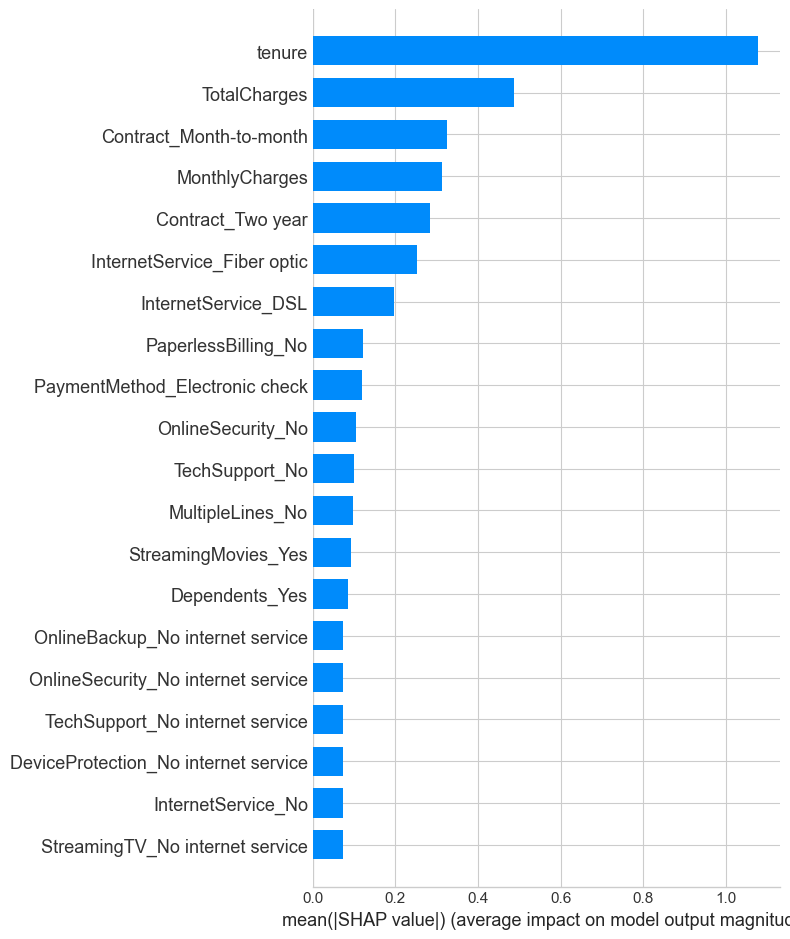

In [ ]:
# ---------------------------------------------------------
# 1. Create SHAP explainer for Logistic Regression
# ---------------------------------------------------------
# We use the training data as background distribution.
# This is correct and avoids data leakage.

explainer = shap.LinearExplainer(
    model,                     
    X_train,        
    feature_names=feature_names
)

# ---------------------------------------------------------
# 2. Compute SHAP values on training data
# ---------------------------------------------------------
shap_values = explainer(X_train)

# ---------------------------------------------------------
# 3. Global feature importance (bar plot)
# ---------------------------------------------------------
# Shows which features contribute the most on average

shap.summary_plot(
    shap_values.values,
    X_train,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)



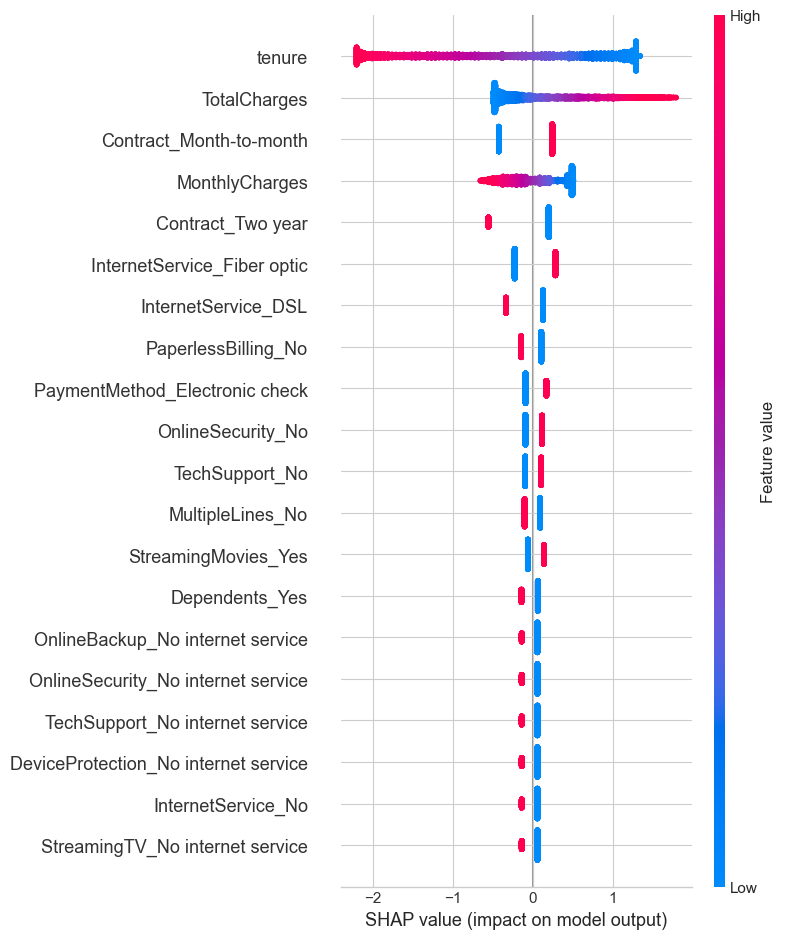

In [ ]:
# ---------------------------------------------------------
# 4. Global distribution & direction of effects
# ---------------------------------------------------------
# Shows how high/low feature values impact churn

shap.summary_plot(
    shap_values.values,
    X_train,
    feature_names=feature_names,
    show=True
)



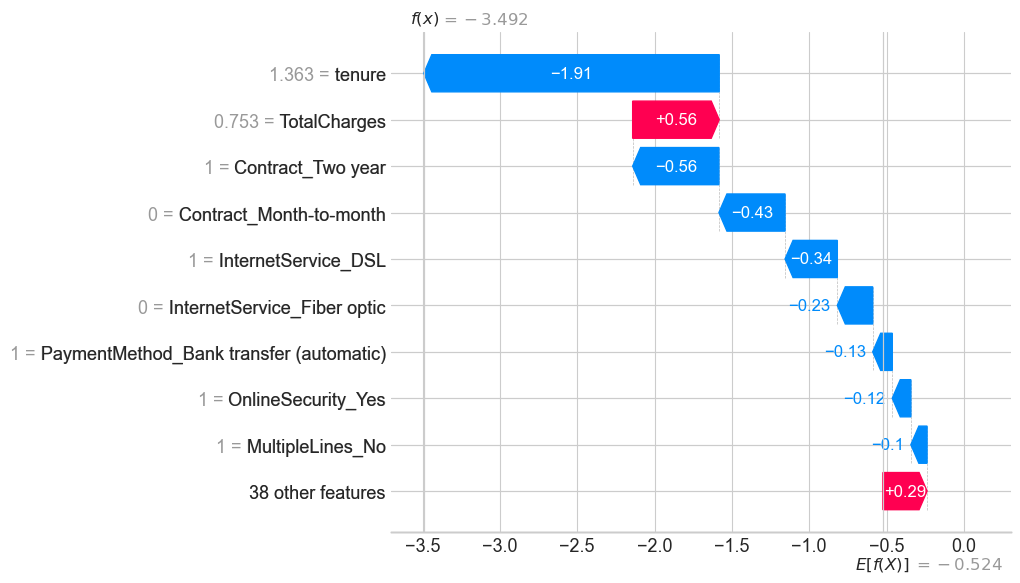

In [ ]:
# ---------------------------------------------------------
# 5. Local explanation for a single observation
# ---------------------------------------------------------
# Explains why the model made a specific prediction

idx = 0  # index of the observation to explain

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.values[idx],
        base_values=shap_values.base_values[idx],
        data=X_train[idx],
        feature_names=feature_names
    )
)

### SHAP – summary

- SHAP analysis confirms the main churn drivers identified earlier:
  tenure, contract type, monthly charges, and total charges
- Feature effects are consistent across global and local explanations
- No contradictory signals were identified compared to coefficient-based importance

Based on this analysis:
- Feature selection decisions are validated
- Redundant or weak features can be safely removed
- Feature engineering can proceed with high confidence

This concludes the explainability phase and directly informs
the next steps: feature engineering and hyperparameter tuning.

## Conclusion

This notebook identifies and validates the key drivers of customer churn using an interpretable Logistic Regression model and SHAP explanations.

### Key outcomes
- Churn is primarily driven by **tenure**, **contract type**, **monthly charges**, and **internet-related services**.
- SHAP analysis confirms both the **importance** and the **direction** of these effects.
- Several features show **negligible impact** and can be considered for removal.
- `TotalCharges` is redundant due to strong multicollinearity with `tenure` and `MonthlyCharges`.

### Decisions
- Keep the most influential features (tenure, contract, pricing, internet services).
- Drop or transform redundant features (`TotalCharges`).
- Simplify weak or low-impact one-hot encoded features if model performance is preserved.

### Next step
Use these decisions to perform **feature engineering**, then proceed to **hyperparameter tuning and final model training**.

This notebook is finalized and serves as the reference for feature selection.